In [52]:
import pandas as pd
import numpy as np
!pip install xgboost

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)


In [18]:
df = pd.read_excel(r'C:\MajorProject\Crop_recommendation_dataset.xlsx')

Exploratory Data Analysis

In [19]:
df.head()

,Region,District,Sub-District,Season,Soil Type,Soil ph,Phosphorus(kg/ha),potassium(kg/ha),Nitrogen(kg/ha),Average Temperature(in celsius),Average Rainfall(in mm),Popular crops
0,Vidarbha,Nagpur,Nagpur (Urban),Summer,Black,7.4,17,215,230,35.15,1100,Sunflower
1,Vidarbha,Nagpur,Nagpur (Urban),Winter,Black,7.4,17,215,230,19.00,1100,"Wheat,Gram"
2,Vidarbha,Nagpur,Nagpur (Urban),Monsoon,Black,7.4,17,215,230,26.95,1100,"Soybean, paddy,Maize"
3,Vidarbha,Nagpur,Nagpur (Rural),Summer,Black,7.2,18,220,240,35.15,1150,"Moong,Vegetables"
4,Vidarbha,Nagpur,Nagpur (Rural),Winter,Black,7.2,18,220,240,19.00,1150,"Wheat,Gram"


In [20]:
df.shape #rows and columns

(354, 12)

In [21]:
df.dtypes #data types of each column

Region                              object
District                            object
Sub-District                        object
Season                              object
Soil Type                           object
Soil ph                            float64
Phosphorus(kg/ha)                    int64
potassium(kg/ha)                     int64
Nitrogen(kg/ha)                      int64
Average Temperature(in celsius)    float64
Average Rainfall(in mm)              int64
Popular crops                       object
dtype: object

In [22]:
df.isnull().sum() #checking for null values

Region                             0
District                           0
Sub-District                       0
Season                             0
Soil Type                          0
Soil ph                            0
Phosphorus(kg/ha)                  0
potassium(kg/ha)                   0
Nitrogen(kg/ha)                    0
Average Temperature(in celsius)    0
Average Rainfall(in mm)            0
Popular crops                      0
dtype: int64

In [23]:
df.describe() #statistical measures of the data

,Soil ph,Phosphorus(kg/ha),potassium(kg/ha),Nitrogen(kg/ha),Average Temperature(in celsius),Average Rainfall(in mm)
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,7.031356,12.838983,245.974576,265.830508,27.561441,1145.084746
std,0.306224,2.466674,27.475189,18.831279,5.406811,230.516402
min,6.100000,8.000000,195.000000,215.000000,17.000000,845.000000
25%,6.800000,11.000000,220.000000,250.000000,21.700000,1000.000000
50%,7.200000,12.000000,261.500000,274.000000,27.500000,1095.000000
75%,7.300000,14.000000,270.000000,278.000000,32.900000,1350.000000
max,7.500000,20.000000,290.000000,300.000000,42.400000,1900.000000


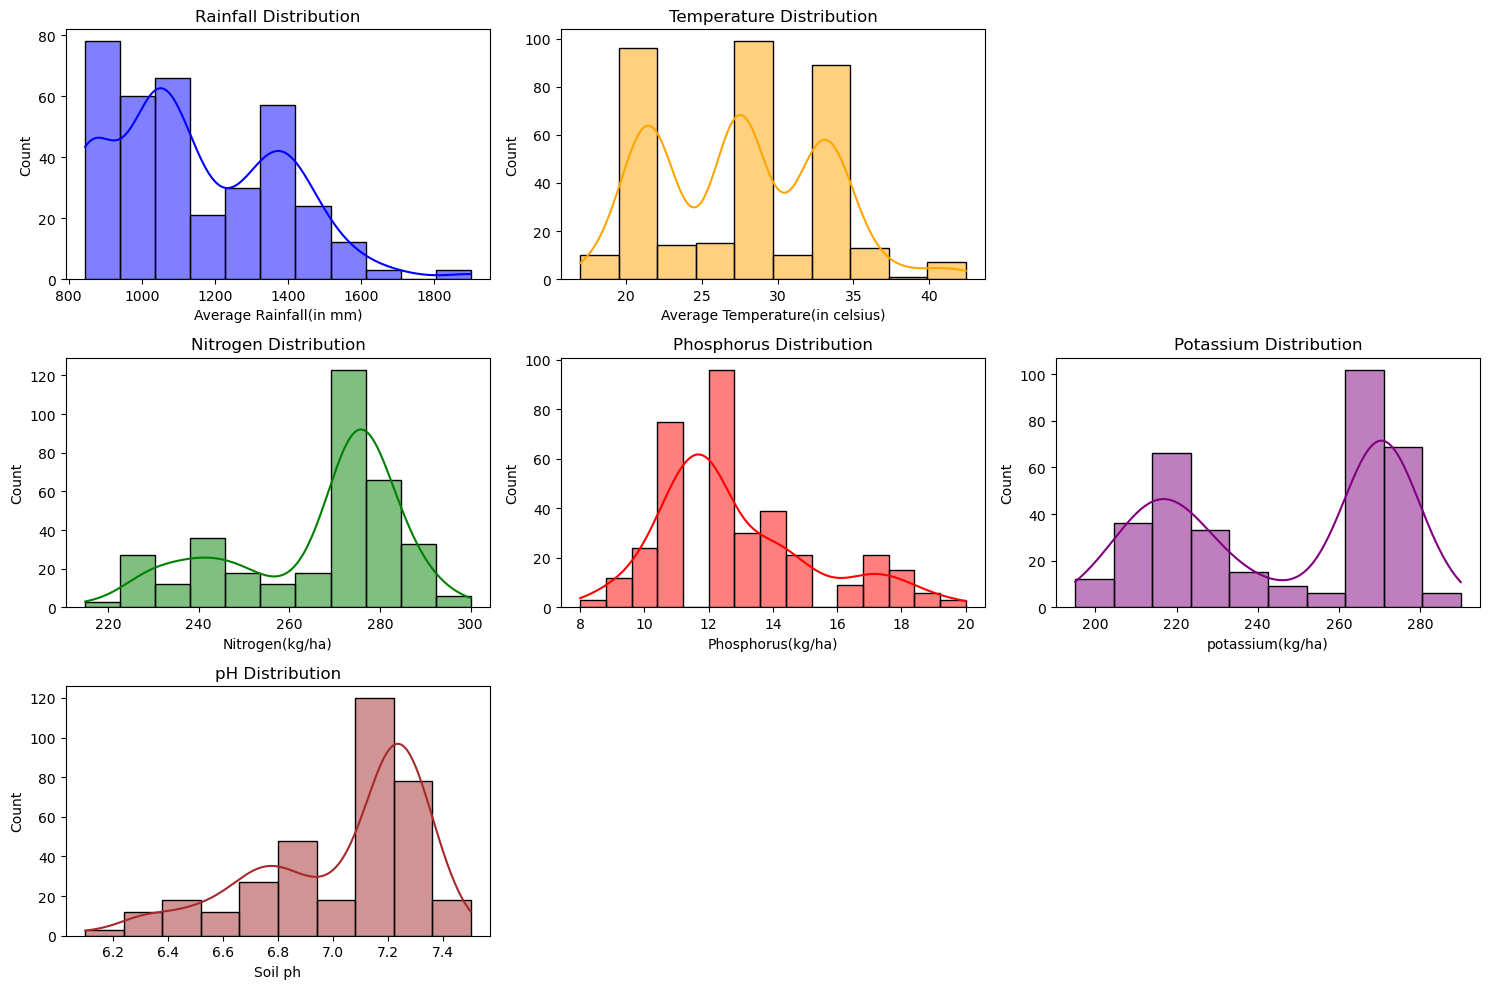

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns   

fig, ax = plt.subplots(3, 3, figsize=(15, 10))

sns.histplot(df['Average Rainfall(in mm)'], ax=ax[0, 0], kde=True, color='blue').set_title('Rainfall Distribution')
sns.histplot(df['Average Temperature(in celsius)'], ax=ax[0, 1], kde=True, color='orange').set_title('Temperature Distribution')
sns.histplot(df['Nitrogen(kg/ha)'], ax=ax[1, 0], kde=True, color='green').set_title('Nitrogen Distribution')
sns.histplot(df['Phosphorus(kg/ha)'], ax=ax[1, 1], kde=True, color='red').set_title('Phosphorus Distribution')
sns.histplot(df['potassium(kg/ha)'], ax=ax[1, 2], kde=True, color='purple').set_title('Potassium Distribution')
sns.histplot(df['Soil ph'], ax=ax[2, 0], kde=True, color='brown').set_title('pH Distribution')

# Hide unused subplots (since 3x3 = 9 but we only used 6)
for i in range(3):
    for j in range(3):
        if (i, j) not in [(0,0),(0,1),(1,0),(1,1),(1,2),(2,0)]:
            fig.delaxes(ax[i, j])

plt.tight_layout()
plt.show()


Preprocessing of data 


In [34]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
def Preprocess(df):
    df_processed = df.copy()


    #one hot encoding on categorical variable
    categorical_cols = ['Region', 'District', 'Sub-District', 'Season']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols)

    # Multi-label binarization for the 'popular crops' and 'Soil type' column'
    mlb = MultiLabelBinarizer()
    df_processed['Popular crops'] = df_processed['Popular crops'].apply(lambda x: x.split(','))
    df_processed = df_processed.join(pd.DataFrame(mlb.fit_transform(df_processed['Popular crops']),
                                                  columns=mlb.classes_,
                                                  index=df_processed.index))
    df_processed = df_processed.drop('Popular crops', axis=1)

    df_processed['Soil Type'] = df_processed['Soil Type'].apply(lambda x: x.split(','))
    df_processed = df_processed.join(pd.DataFrame(mlb.fit_transform(df_processed['Soil Type']),
                                                  columns=mlb.classes_,
                                                  index=df_processed.index))
    df_processed = df_processed.drop('Soil Type', axis=1)

    # Standardizing numerical features
    numerical_cols = ['Average Rainfall(in mm)', 'Average Temperature(in celsius)', 'Nitrogen(kg/ha)', 
                      'Phosphorus(kg/ha)', 'potassium(kg/ha)', 'Soil ph']
    scaler = StandardScaler()
    df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])
    return df_processed


In [35]:
df_processed = Preprocess(df)

Model Training & Evaluation

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
# Example: crops are the last N columns (after preprocessing)
crop_cols = [col for col in df_processed.columns if col not in 
             ['Soil ph', 'Phosphorus(kg/ha)', 'potassium(kg/ha)', 
              'Nitrogen(kg/ha)', 'Average Temperature(in celsius)', 
              'Average Rainfall(in mm)'] 
             and not col.startswith(('Region_', 'District_', 'Sub-District_', 'Season_', 'Soil Type_'))]


X = df_processed.drop(columns=crop_cols)
y = df_processed[crop_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

def tune_model(model_type, X_train, y_train, cv=3, n_iter=10):
    """
    Hyperparameter tuning for Random Forest and XGBoost (multi-label).
    
    Args:
        model_type (str): 'rf' for RandomForest, 'xgb' for XGBoost
        X_train (DataFrame): training features
        y_train (DataFrame): training labels
        cv (int): cross-validation folds
        n_iter (int): number of random search iterations
    
    Returns:
        best_model, best_params, best_score
    """
    
    if model_type == 'rf':
        base_model = RandomForestClassifier(random_state=42)
        param_grid = {
            "estimator__n_estimators": [100, 200, 300, 500],
            "estimator__max_depth": [None, 5, 10, 20],
            "estimator__min_samples_split": [2, 5, 10],
            "estimator__min_samples_leaf": [1, 2, 4]
        }
        
    elif model_type == 'xgb':
        base_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        param_grid = {
            "estimator__n_estimators": [100, 200, 300],
            "estimator__max_depth": [3, 5, 7, 10],
            "estimator__learning_rate": [0.01, 0.1, 0.2],
            "estimator__subsample": [0.7, 0.8, 1.0],
            "estimator__colsample_bytree": [0.7, 0.8, 1.0]
        }
        
    else:
        raise ValueError("Invalid model_type. Use 'rf' or 'xgb'.")
    
    # Wrap in OneVsRest for multi-label classification
    model = OneVsRestClassifier(base_model, n_jobs=-1)
    
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring="f1_micro",
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    print(f"\nBest parameters for {model_type.upper()}: {search.best_params_}")
    print(f"Best F1_micro score: {search.best_score_:.4f}")
    return search.best_estimator_, search.best_params_, search.best_score_


In [56]:
# Random Forest tuning
best_rf, rf_params, rf_score = tune_model("rf", X_train, y_train)

# XGBoost tuning
best_xgb, xgb_params, xgb_score = tune_model("xgb", X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for RF: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 20}
Best F1_micro score: 0.3785
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for XGB: {'estimator__subsample': 1.0, 'estimator__n_estimators': 200, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1.0}
Best F1_micro score: 0.4758


In [59]:
#model training using RandomForestClassifier
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=10, min_samples_leaf=1, max_depth=20), n_jobs=-1)
rf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (micro):", f1_score(y_test, y_pred, average='micro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred))



Accuracy: 0.028169014084507043
F1 Score (micro): 0.38873239436619716
F1 Score (macro): 0.07412113760691653
Hamming Loss: 0.016793066088840736


c:\Users\akanksha meshram\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

# Define XGBoost model wrapped in OneVsRest
xgb = OneVsRestClassifier(
    XGBClassifier(
        subsample=1.0,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=1.0,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

# Train
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score (micro):", f1_score(y_test, y_pred_xgb, average='micro'))
print("F1 Score (macro):", f1_score(y_test, y_pred_xgb, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred_xgb))

c:\Users\akanksha meshram\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:56:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\akanksha meshram\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:56:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\akanksha meshram\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:56:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\akanksha meshram\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:56:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

Accuracy: 0.028169014084507043
F1 Score (micro): 0.4752941176470588
F1 Score (macro): 0.1331179887090308
Hamming Loss: 0.017257390496827115


c:\Users\akanksha meshram\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
